In [ ]:
!pip install pandas
!pip install qiskit==0.39.2
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scipy


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import shin_metiu_full as sf
import matplotlib as mpl

# import ipywidgets as widgets
import pandas as pd
import seaborn as sns

from ansatze import hweff_ansatz
from qiskit import Aer
from exact_simulator import prep_ham, simulation, inner

from auto_plotter import autoplotter, prep_dfs
import warnings

mpl.rcParams['text.usetex'] = False

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
sns.set_context(
    "talk",
    rc={
        "text.usetex": True,
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "legend.loc": "lower left",
        "legend.frameon": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    },
)
file = "results/LONG0.json"
data = json.load(open(file))
backend = Aer.get_backend("statevector_simulator")
data.keys()

/home/danielb/miniconda3/envs/qiskit/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


dict_keys(['QC_energy_el', 'dt', 'depth', 'r_r', 'r_f', 'r_l', 'L', 'res', 'trotter_steps', 'parameterized', 'padding', 'fidelity_to_ideal', 'fidelity_to_exact', 'QC_energy_Tnuc', 'QC_energy_Vnuc', 'QC_coefficients', 'QC_energy', 'ideal_energy', 'total_energy', 'ideal_coefficients', 'ideal_forces_el', 'ideal_forces_nuc', 'ideal_tot_forces', 'ideal_velocities', 'ideal_positions', 'ideal_energy_el', 'ideal_energy_Tnuc', 'ideal_energy_Vnuc', 'exact_coefficients', 'exact_forces_el', 'exact_forces_nuc', 'exact_tot_forces', 'exact_velocities', 'exact_positions', 'exact_energy_el', 'exact_energy_Tnuc', 'exact_energy_Vnuc', 'exact_energy', 'force', 'err_force', 'energy', 'err_energy', 'init_F', 'QC_positions', 'QC_velocities', 'QC_tot_forces', 'QC_forces_nuc', 'QC_forces_el', 'final_F', 'err_init_F', 'err_fin_F', 'iter_number', 'times', 'params', 'tot_steps', 'final_i'])

In [2]:
numfiles = 150
max_times =700
results = []
dfs = []
fin_files = 0
for d in range(3, 6):
    for tr in [1,2,3,4,10]:
        for r in range(10):
            try:
                file = f"results/depth_trotter_an/d_{d}_tr_{tr}_rep{r}.json"
                data = json.load(open(file))
                if data['final_i'] < 1000:
                    print('not_complte')
                    raise('not complete')
                results.append(data)
                for j in ['QC','ideal','exact']:
                    datadf = pd.DataFrame(data[f'{j}_coefficients'])
                    datadf = datadf.reset_index()
                    datadf = datadf.melt(id_vars='index',var_name='Adiabatic state',value_name='Population')
                    datadf['Setup:'] = f'{j}'
                    datadf['sample'] = fin_files
                    datadf['Depth'] = data['depth']
                    datadf['Trotter Steps'] = data['trotter_steps']
                    datadf['Time'] = datadf['index']*data['dt']
                    dfs.append(datadf)
                fin_files+=1
            except:
                print(f"didn't find {d},{tr},{r}")
numfiles=fin_files
datadf = pd.concat(dfs,ignore_index=True)
stuff = [
    "fidelity_to_ideal",
    "fidelity_to_exact",
    "ideal_forces_el",
    "ideal_forces_nuc",
    "ideal_tot_forces",
    "ideal_velocities",
    "ideal_positions",
    "ideal_energy_el",
    "ideal_energy_Tnuc",
    "ideal_energy_Vnuc",
    "exact_forces_el",
    "exact_forces_nuc",
    "exact_tot_forces",
    "exact_velocities",
    "exact_positions",
    "exact_energy_el",
    "exact_energy_Tnuc",
    "exact_energy_Vnuc",
    "QC_forces_el",
    "QC_forces_nuc",
    "QC_tot_forces",
    "QC_velocities",
    "QC_positions",
    "QC_energy_el",
    "QC_energy_Tnuc",
    "QC_energy_Vnuc",
    "force",
    "err_force",
    "energy",
    "err_energy",
    "init_F",
    "final_F",
    "err_init_F",
    "err_fin_F",
    "iter_number",
    "times",
    'depth',
    'trotter_steps'
]

store = {i: [] for i in stuff}
store["sample"] = []

for i in range(numfiles):
    for j in stuff:
        try:
            store[j].extend(results[i][j][0:max_times])
        except:
            store[j].extend([results[i][j]]*max_times)
        
        # print(len(store[j]))
    store["sample"].extend([i] * max_times)
# print(len(store["sample"]))

df = pd.DataFrame(store)
df["diff_ideal_exact"] = np.abs(df["fidelity_to_exact"] - df["fidelity_to_ideal"])
df['QC_energy'] = df['QC_energy_el']+df['QC_energy_Vnuc']+df['QC_energy_Tnuc']
df['ideal_energy'] = df['ideal_energy_el']+df['ideal_energy_Vnuc']+df['ideal_energy_Tnuc']
df['exact_energy'] = df['exact_energy_el']+df['exact_energy_Vnuc']+df['exact_energy_Tnuc']

coeff_names  ={'exact_coefficients':'Exact',
'ideal_coefficients':'Ideal',
'QC_coefficients': 'TDVQP'}

store_coef = {coeff_names[i]: [] for i in coeff_names}
store_coef['Time'] = []
store_coef['State'] = []
store_coef["Sample"] = []
for i in range(numfiles):
    for j in coeff_names:
        for k, res in enumerate(results[i][j][0:max_times]):        
            store_coef[coeff_names[j]].extend(res[0:15]) # only really need highest 5 populations even in larger simulations with superpositions.
            if j == 'exact_coefficients':
                store_coef['Time'].extend([results[i]['times'][k]]*15)
                store_coef["Sample"].extend([i] * 15)
                store_coef['State'].extend(list(range(15)))
                
df_coef = pd.DataFrame(store_coef).melt(id_vars=('Time','State','Sample'),value_name='Population',var_name='Type')


didn't find 3,4,9
didn't find 3,10,0
didn't find 3,10,1
didn't find 3,10,2
didn't find 3,10,3
didn't find 3,10,4
didn't find 3,10,5
didn't find 3,10,6
didn't find 3,10,7
didn't find 3,10,8
didn't find 3,10,9
didn't find 4,10,5
didn't find 4,10,9
didn't find 5,10,2
didn't find 5,10,4
didn't find 5,10,5
not_complte
didn't find 5,10,9


In [4]:
df = df.rename({'depth':'Depth','trotter_steps':'Trotter Steps'}, axis='columns')

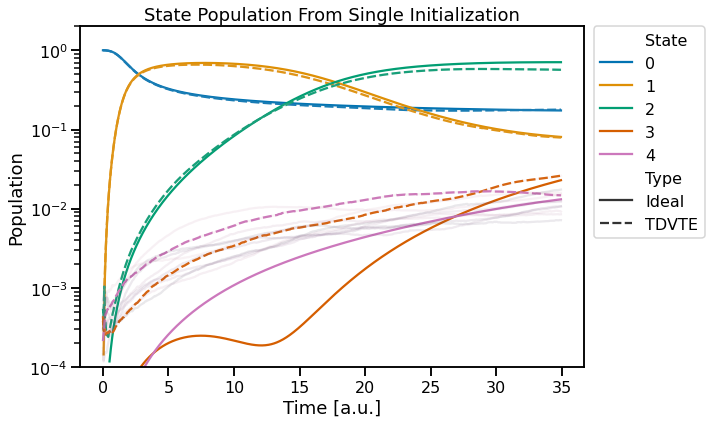

In [20]:
fig, ax = plt.subplots(figsize=((10, 6)))
sns.lineplot(data=df_coef.query('State<5 & Population>1e-4 &Type!="Exact"'),x='Time',y='Population',hue='State',style='Type',ci=None,ax=ax,palette=sns.color_palette("colorblind"))
sns.lineplot(data=df_coef.query('State<15 & Population>1e-4 &Type=="TDVQP"'),x='Time',y='Population',hue='State',style='Type',ci=None,ax=ax,legend=None,alpha=0.1)
plt.xlabel(r'Time [a.u.]')
# plt.ylabel(r'Population')
plt.ylim([1e-4,2])
plt.yscale('log')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title(r'State Population From Single Initialization')
plt.tight_layout()
# plt.savefig('./custom_plots/single_populations.pdf')

In [21]:
dash_list = sns._core.unique_dashes(df['sample'].unique().size+1)
style = {key:value for key,value in zip(df['sample'].unique(), dash_list[1:])}


AttributeError: module 'seaborn._core' has no attribute 'unique_dashes'

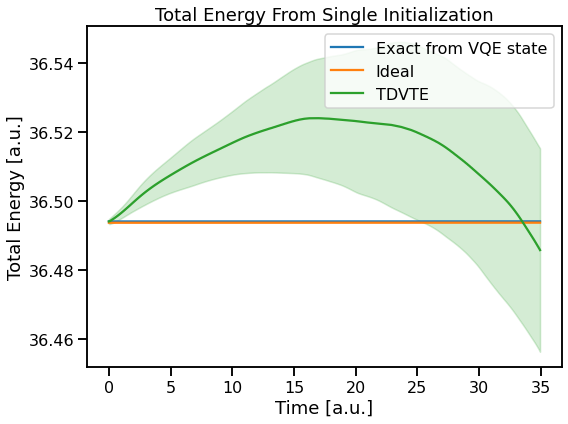

In [22]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="exact_energy", ci=None, ax=ax, label='Exact from VQE state')
sns.lineplot(data=df, x="times", y="ideal_energy", ci=None, ax=ax,label='Ideal')
sns.lineplot(data=df, x="times", y="QC_energy", ci='sd', ax=ax, palette="Set2",label='TDVQP')
plt.ylabel(r'Total Energy [a.u.]')
plt.xlabel(r'Time [a.u.]')
plt.title(r'Total Energy From Single Initialization')
plt.tight_layout()

# plt.savefig("custom_plots/MD_energy.pdf")

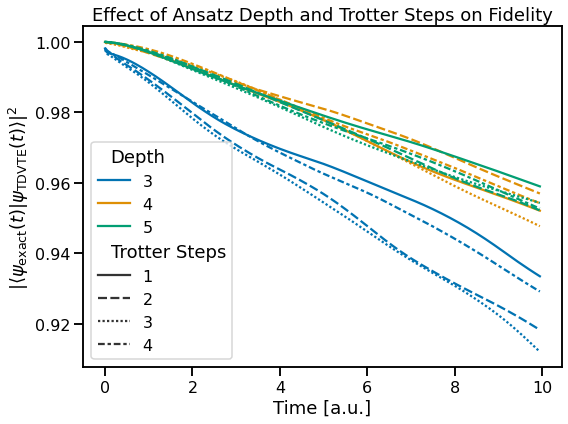

In [8]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df.query('times<10 & `Trotter Steps` < 10'), x="times", y="fidelity_to_ideal", ci=None, estimator='mean', ax=ax, hue='Depth',style='Trotter Steps',palette=sns.color_palette('colorblind'))#, label = 'compared to exact evoltuion of VQE state')
# sns.lineplot(data=df, x="times", y="fidelity_to_ideal", ci="sd", ax=ax, label= 'compared to ideal state evolution')
# plt.ylabel('Fidelity')
ax.set(ylabel=r'$\left |\langle\psi_\mathrm{exact}(t)|\psi_\mathrm{TDVQP}(t)\rangle\right |^2 $',xlabel= r'Time [a.u.]')
plt.title('Effect of Ansatz Depth and Trotter Steps on Fidelity')
plt.tight_layout()

plt.savefig("custom_plots/depth_trotter_fidelity.pdf")

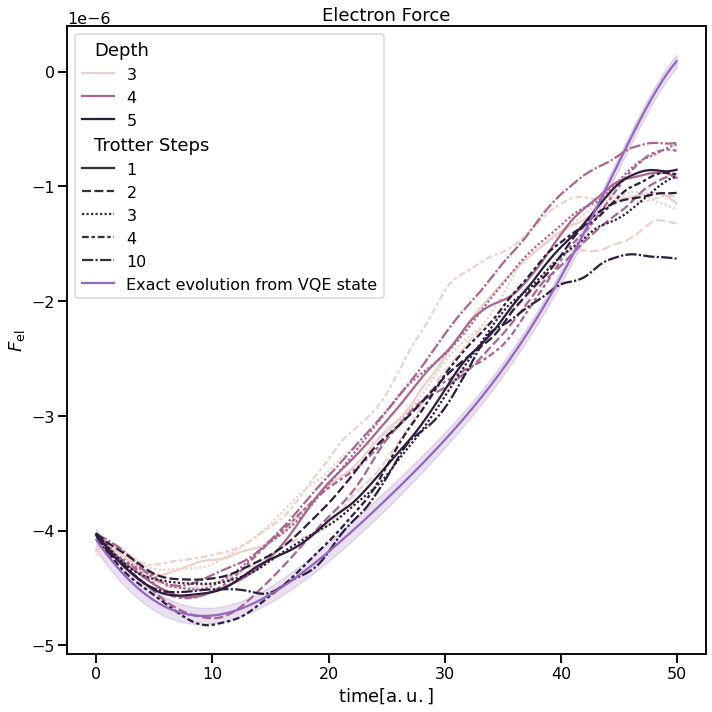

In [22]:
fig, ax = plt.subplots(figsize=((10, 10)))
sns.lineplot(data=df, x="times", y="QC_forces_el", ci=None, ax=ax,hue='Depth',style='Trotter Steps')
sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,label='Exact evolution from VQE state')
# sns.lineplot(data=df, x="times", y="ideal_forces_el", ci="sd", ax=ax, palette="Set2",label='Exact evolution from ideal state')
ax.set(ylabel='$F_\mathrm{el}$',xlabel= r'$\mathrm{time} [\mathrm{a.u.}]$')
plt.title('Electron Force')
plt.tight_layout()
plt.show()

[Text(0, 0.5, '$F_\\mathrm{el}$'),
 Text(0.5, 0, 'Time [a.u.]'),
 Text(0.5, 1.0, 'Electron Force From Single Initialization')]

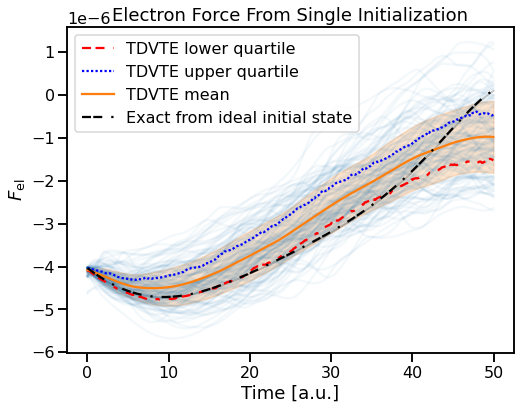

In [23]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="QC_forces_el", ax=ax, units="sample", estimator=None, alpha=0.05,label=None)
plt.legend('')
sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,2,4)], color = 'r', label='TDVQP lower quartile'
)
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='TDVQP median'
# )
sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='TDVQP upper quartile')

sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci="sd", estimator=np.mean, ax=ax, alpha=1, label = 'TDVQP mean'
)

sns.lineplot(data=df, x="times", y="ideal_forces_el", ci="sd", ax=ax,color='black', label='Exact from ideal initial state',style='err_energy', dashes=[(4,1,4)])
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple',label='Exact from VQE initial state')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend([handles[i] for i in [0,2,4,5]], [labels[i] for i in [0,2,4,5]])
ax.set(ylabel='$F_\mathrm{el}$',xlabel= r'Time [a.u.]',title='Electron Force From Single Initialization')
# plt.savefig("custom_plots/S_force.pdf")

[Text(0, 0.5, '$F_\\mathrm{el}$'),
 Text(0.5, 0, 'Time [a.u.]'),
 Text(0.5, 1.0, 'Electron Force From Single Initialization')]

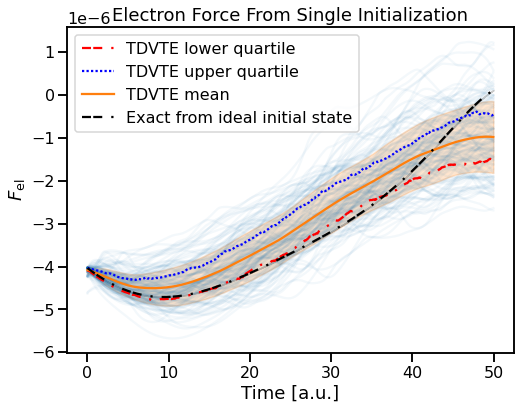

In [24]:

fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, x="times", y="QC_forces_el", ax=ax, units="sample", estimator=None, alpha=0.05,label=None)
plt.legend('')
sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,1,4)], color = 'r', label='TDVQP lower quartile'
)
# sns.lineplot(
#     data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='QC median'
# )
sns.lineplot(
    data=df, x="times", y="QC_forces_el", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='TDVQP upper quartile')

sns.lineplot(
    data=df, x="times", y="QC_forces_el", errorbar=("sd",1), estimator=np.mean, ax=ax, alpha=1, label = 'TDVQP mean'
)

sns.lineplot(data=df, x="times", y="ideal_forces_el", errorbar="sd", ax=ax,color='black', label='Exact from ideal initial state',style='err_energy', dashes=[(4,1,4)])
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple',label='Exact from VQE initial state')
handles, labels = ax.get_legend_handles_labels()

l = plt.legend([handles[i] for i in [0,2,4,5]], [labels[i] for i in [0,2,4,5]])
ax.set(ylabel='$F_\mathrm{el}$',xlabel= r'Time [a.u.]',title='Electron Force From Single Initialization')
# plt.savefig("custom_plots/MD.pdf")

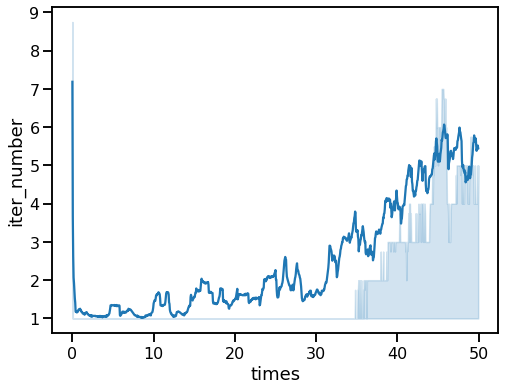

In [21]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df, y="iter_number", x="times", ax=ax, errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 75))))
# sns.lineplot(data=df, x="times", y="iter_number", ax=ax, hue="sample", alpha=0.05)

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,1,4)], color = 'r', label='QC lower quartile'
# )
# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='QC median'
# )

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='QC upper quartile')

# sns.lineplot(
#     data=df, x="times", y="QC_energy_Tnuc", ci="sd", estimator=np.mean, ax=ax, alpha=1, label = 'QC mean'
# )

# sns.lineplot(data=df, x="times", y="ideal_energy_Tnuc", ci="sd", ax=ax,color='black', label = 'Ideal')
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple')

plt.show()

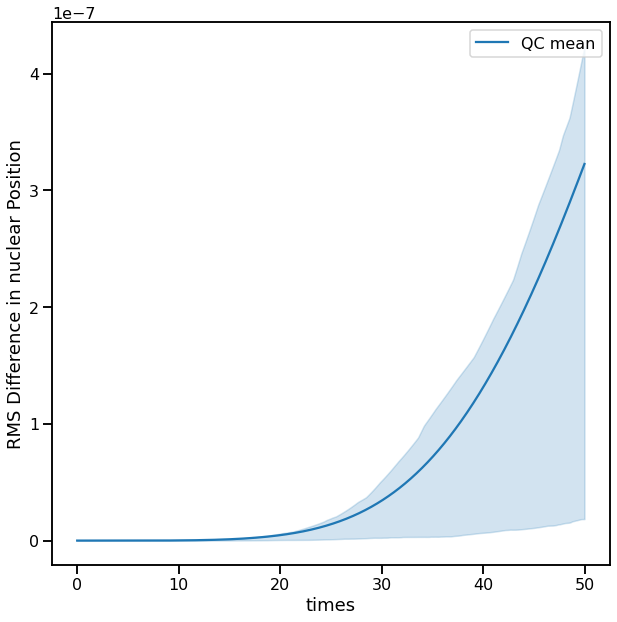

In [14]:
fig, ax = plt.subplots(figsize=((10, 10)))

df['diff_pos'] = (df['QC_positions']-df["ideal_positions"])**2
sns.lineplot(
    data=df, x="times", y="diff_pos", errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 75))), estimator=np.mean, ax=ax, alpha=1, label = 'QC mean'
)

ax.set_ylabel('RMS Difference in nuclear Position')
plt.show()

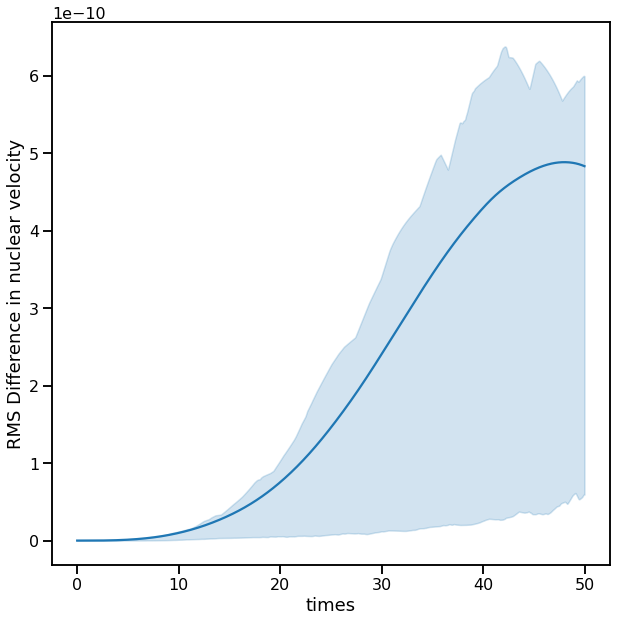

In [15]:
fig, ax = plt.subplots(figsize=((10, 10)))

df['diff_vel'] = (df['QC_velocities']-df["ideal_velocities"])**2
sns.lineplot(
    data=df, x="times", y="diff_vel", errorbar=(lambda x: (np.percentile(x, 25), np.percentile(x, 75))), estimator=np.mean, ax=ax, alpha=1, #label = 'QC mean'
)

ax.set_ylabel('RMS Difference in nuclear velocity')
plt.show()

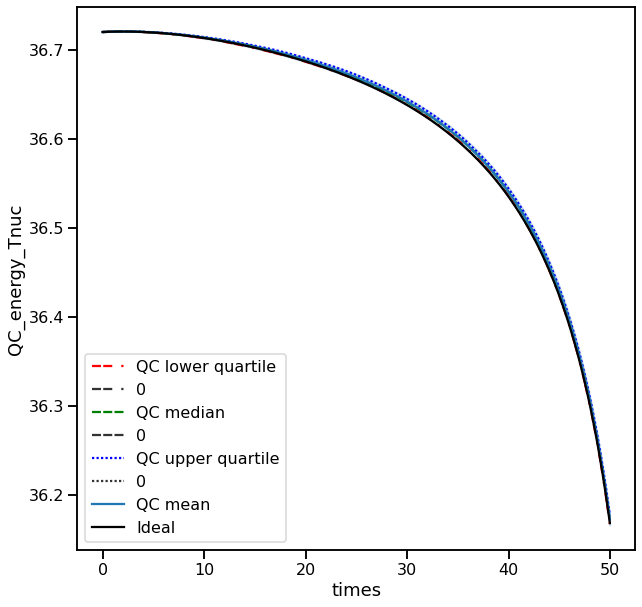

In [16]:
fig, ax = plt.subplots(figsize=((10, 10)))
# sns.lineplot(data=df, x="times", y="QC_energy_el", ax=ax, hue="sample", alpha=0.05)
sns.lineplot(
    data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 25), ax=ax, alpha=1, style='err_energy', dashes=[(4,1,4)], color = 'r', label='QC lower quartile'
)
sns.lineplot(
    data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 50), ax=ax, alpha=1, style='err_energy', dashes=[(4,1)], color = 'g', label='QC median'
)

sns.lineplot(
    data=df, x="times", y="QC_energy_Tnuc", ci=None, estimator=lambda x: np.percentile(x, 75), ax=ax, alpha=1, style='err_energy', color = 'b', dashes=[(1,1)], label='QC upper quartile')

sns.lineplot(
    data=df, x="times", y="QC_energy_Tnuc", ci="sd", estimator=np.mean, ax=ax, alpha=1, label = 'QC mean'
)

sns.lineplot(data=df, x="times", y="ideal_energy_Tnuc", ci="sd", ax=ax,color='black', label = 'Ideal')
# sns.lineplot(data=df, x="times", y="exact_forces_el", ci="sd", ax=ax,color='purple')

plt.show()

In [2]:
files = [
    "padtest_init.json",
    "padtest_2tr.json",
    "padtest_3tr.json",
    "padtest_10tr.json",
    "padtest_init_d5.json",
    "padtest_init_d5_tr2.json",
    "padtest_init_d5_tr3.json",
    "padtest_init_d5_tr10.json",
]

In [3]:
def combine_data(file_list):
    data = []
    df_comp = []
    dfs = []
    ts = []
    for path in file_list:
        data.append(json.load(open(path)))
        t, df, df2 = prep_dfs(path)
        dfs.append(df)
        df_comp.append(df2)
        ts.append(t)
    df_comp = pd.concat(df_comp).reset_index()
    dfs = pd.concat(dfs).reset_index()
    return ts, dfs, df_comp, data


ts, dfs, df_comp, data = combine_data(files)

/home/danielb/OneDrive/CODE/Heidelberg/Time dependent VQE/shin_metiu_full.py:250: RuntimeWarning: invalid value encountered in divide
  sc = erf(abs_r12 / gamma) / abs_r12
/home/danielb/OneDrive/CODE/Heidelberg/Time dependent VQE/shin_metiu_full.py:258: RuntimeWarning: invalid value encountered in divide
  out = r12 * erf(abs_r12 / gamma) / (
/home/danielb/OneDrive/CODE/Heidelberg/Time dependent VQE/shin_metiu_full.py:260: RuntimeWarning: invalid value encountered in divide
  ) - two_over_root_pi * r12 * np.exp(-(abs_r12**2) / (gamma**2)) / (


In [13]:
df

,fidelity_to_ideal,fidelity_to_exact,ideal_forces_el,ideal_forces_nuc,ideal_tot_forces,ideal_velocities,ideal_positions,ideal_energy_el,ideal_energy_Tnuc,ideal_energy_Vnuc,...,iter_number,times,depth,trotter_steps,sample,diff_ideal_exact,QC_energy,ideal_energy,exact_energy,Difference of Force from ideal
0,0.997113,1.000000,-4.035099e-06,0.000006,0.000002,0.200000,-2.000000,-0.446613,36.720000,0.220290,...,24,0.00,3,1,0,0.002887,36.496332,36.493677,36.496332,9.358362e-08
1,0.995488,0.999984,-4.042323e-06,0.000006,0.000001,0.200000,-1.990000,-0.446538,36.720028,0.220188,...,1,0.05,3,1,0,0.004496,36.496367,36.493677,36.496332,8.545257e-08
2,0.995441,0.999937,-4.049512e-06,0.000005,0.000001,0.200000,-1.980000,-0.446464,36.720055,0.220087,...,1,0.10,3,1,0,0.004497,36.496403,36.493677,36.496332,7.774489e-08
3,0.995376,0.999865,-4.056665e-06,0.000005,0.000001,0.200000,-1.970000,-0.446390,36.720081,0.219986,...,1,0.15,3,1,0,0.004489,36.496541,36.493677,36.496332,7.047207e-08
4,0.995298,0.999770,-4.063783e-06,0.000005,0.000001,0.200000,-1.960000,-0.446315,36.720106,0.219886,...,1,0.20,3,1,0,0.004471,36.496578,36.493677,36.496332,6.363251e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132995,0.633491,0.630501,8.575375e-08,-0.000221,-0.000221,0.198537,7.936156,-0.387834,36.184765,0.696802,...,1,49.75,5,10,132,0.002990,36.100641,36.493733,36.493811,2.271290e-06
132996,0.633258,0.630285,9.193520e-08,-0.000224,-0.000224,0.198526,7.946083,-0.387835,36.180714,0.700854,...,1,49.80,5,10,132,0.002972,36.096482,36.493733,36.493811,2.279299e-06
132997,0.633001,0.630047,9.802595e-08,-0.000227,-0.000227,0.198515,7.956009,-0.387837,36.176611,0.704959,...,1,49.85,5,10,132,0.002955,36.092110,36.493733,36.493811,2.287064e-06
132998,0.632720,0.629784,1.040249e-07,-0.000230,-0.000230,0.198503,7.965934,-0.387839,36.172455,0.709117,...,1,49.90,5,10,132,0.002936,36.087868,36.493733,36.493811,2.294601e-06


In [8]:
df["Difference of Force from ideal"] = np.sqrt(
    (df["ideal_forces_el"] - df["QC_forces_el"]) ** 2
)

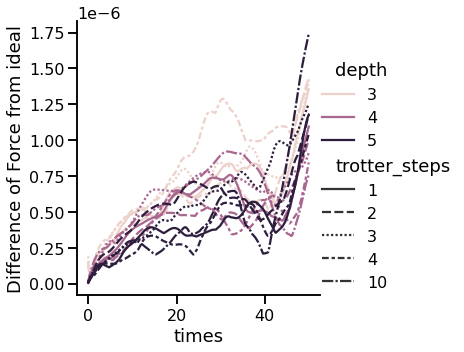

In [17]:
sns.relplot(
    data=df,
    x="times",
    y="Difference of Force from ideal",
    style="trotter_steps",
    hue="depth",
    kind="line",
    ci=None
)
plt.savefig("force_difference.svg")

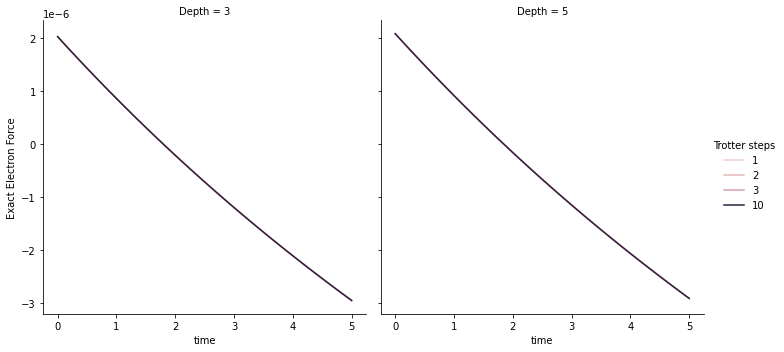

In [8]:
sns.relplot(
    data=df_comp,
    x="time",
    y="Exact Electron Force",
    hue="Trotter steps",
    col="Depth",
    kind="line",
)

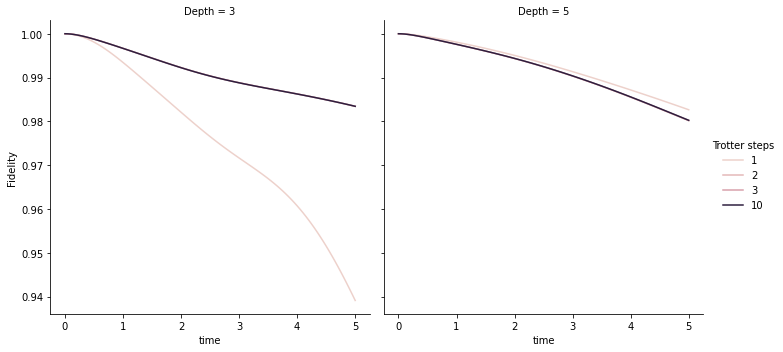

In [14]:
sns.relplot(
    data=df_comp, x="time", y="Fidelity", hue="Trotter steps", col="Depth", kind="line"
)

In [17]:
res = np.asarray(
    backend.run(
        hweff_ansatz(np.int(np.log2(data["res"])), data["depth"], data["params"][0])
    )
    .result()
    .get_statevector()
)
t = simulation(
    data["dt"],
    len(data["positions"]),
    data["r_f"],
    data["r_l"],
    data["r_r"],
    data["res"],
    data["L"],
    x_0=data["positions"][0],
    v_0=data["velocities"][0],
    vector=res,
    parameterized=data["parameterized"],
)
store_c = np.zeros((len(data["params"]), data["res"]))
store_fel = np.zeros(len(data["params"]), dtype=np.complex128)
QC_fel = np.zeros(len(data["params"]), dtype=np.complex128)
fidelity = []


def plot(p):
    fig = plt.figure()
    l = len(data["times"])
    gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[2, 1])
    axs = gs.subplots(sharex=True)
    fig.suptitle(p)
    axs[1].plot(
        np.abs(np.array(data[f"exact_{p}"])[0:l] - np.array(data[f"{p}"])[0:l]),
        color="red",
        label="difference",
    )
    axs[0].plot(
        (np.array(data[f"exact_{p}"]))[0:l],
        color="pink",
        label="Exact from ideal state",
    )
    axs[0].plot((np.array(data[f"{p}"]))[0:l], color="green", label="QC", dashes=[3, 1])

    if p == "forces_el":
        axs[0].plot(
            t.store_fel, color="black", label="Exact from QC state", dashes=[4, 3]
        )[0:l]
    # axs[0].set_yscale('log')
    axs[0].legend()
    axs[1].legend(loc=4)
    # axs[0].set_yscale('log')
    axs[1].set_yscale("log")
    plt.show()


resses = []
for i, val in enumerate(data["params"]):
    res = np.asarray(backend.run(hweff_ansatz(4, 3, val)).result().get_statevector())
    H, En, Q, dHdr, xgrid, dHdr_nuc, V_nuc = prep_ham(
        data["positions"][i],
        data["r_f"],
        data["r_l"],
        data["r_r"],
        data["res"],
        data["L"],
    )
    resses.append(res)
    store_c[i] = np.abs(np.conj(Q).T @ res) ** 2
    store_fel[i] = -1 * inner(t.store_psi[i], dHdr) / 1836
    QC_fel[i] = -1 * inner(res, dHdr) / 1836
    fidelity.append(np.abs(np.inner(np.conjugate(res), t.store_psi[i])) ** 2)
    # -np.inner(np.conj(t.store_psi[i]).T,np.array(dHdr,dtype=np.complex128))[0]/1836
    # -np.conj(t.store_psi[i][::-1]).T@dHdr@t.store_psi[i][::-1]/1836
df = pd.DataFrame(store_c, columns=range(data["res"]), index=range(len(data["params"])))
df = df.rename_axis("time").reset_index().melt("time", var_name="state")
df["time"] = df["time"] * data["dt"]
df["position"] = data["positions"][0:-1] * 16
df["velocity"] = data["velocities"][0:-1] * 16

ValueError: dimension mismatch

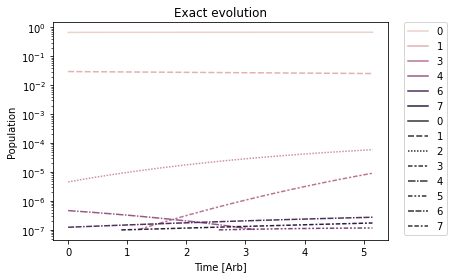

In [18]:
sns.lineplot(
    data=t.coef_df.query("state<15 & value>1e-7").abs(),
    x="time",
    y="value",
    hue="state",
    style="state",
).set(yscale="log", ylabel="Population", xlabel="Time [Arb]", title="Exact evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

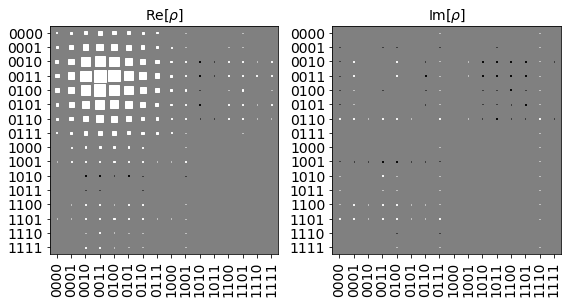

In [12]:
import qiskit.visualization as qv

qv.plot_state_hinton(t.store_psi[0])

In [13]:
import qiskit.visualization as qv

qv.plot_state_hinton(t.store_psi[1000])

IndexError: index 1000 is out of bounds for axis 0 with size 104

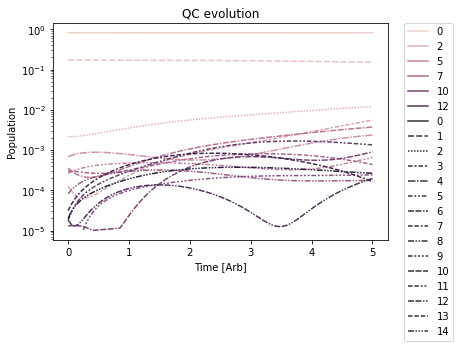

In [19]:
sns.lineplot(
    data=df.query("state<15 &value>1e-5"),
    x="time",
    y="value",
    hue="state",
    style="state",
).set(yscale="log", ylabel="Population", xlabel="Time [Arb]", title="QC evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

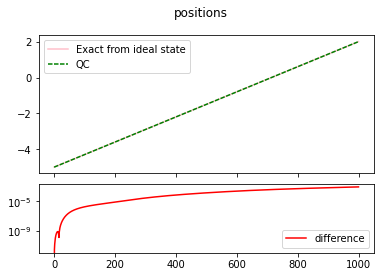

In [9]:
plot("positions")

In [161]:
t = simulation(steps=1, resolution=16)
t.store_c

array([[1.00000000e+00, 1.07657533e-32, 4.27642354e-48, 4.33334237e-34,
        1.12103877e-44, 0.00000000e+00, 1.88079096e-35, 1.17549435e-38,
        7.52316385e-37, 2.64486229e-38, 1.88079096e-37, 0.00000000e+00,
        2.93873588e-37, 1.17549435e-38, 4.48415509e-44, 7.34683969e-40],
       [1.00000000e+00, 5.05754679e-14, 8.18319437e-32, 9.22948195e-18,
        4.69102334e-29, 3.75452699e-17, 4.82357498e-20, 5.01052043e-23,
        9.56466726e-21, 2.58988559e-22, 9.96705847e-19, 5.96386143e-21,
        3.17173152e-21, 8.21186746e-22, 2.19452594e-27, 8.77510299e-23],
       [1.00000000e+00, 8.09177408e-13, 1.30911716e-30, 1.47631420e-16,
        7.50128688e-28, 6.00713346e-16, 7.72093678e-19, 8.01941999e-22,
        1.53071447e-19, 4.14383166e-21, 1.59470612e-17, 9.54404554e-20,
        5.07559509e-20, 1.31407819e-20, 3.51166197e-26, 1.40418160e-21]])

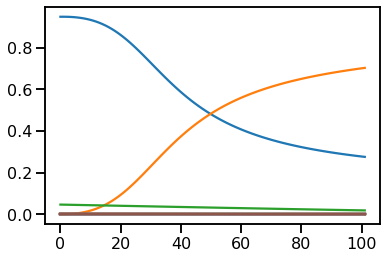

In [173]:
a = [[i[n] for i in data["ideal_coefficients"]] for n in range(len(data["ideal_coefficients"][0]))]
for i in a:
    plt.plot(i)
# plt.yscale('log')

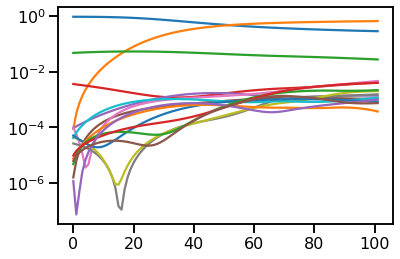

In [174]:
a = [[i[n] for i in data["QC_coefficients"]] for n in range(len(data["QC_coefficients"][0]))]
for i in a:
    plt.plot(i)
plt.yscale('log')